[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_session_5.ipynb)

# Kadenze Session 5 - Generative Models

In [0]:
#!rm -rf ./*
!git clone https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-5/* .

In [0]:
!pip uninstall -y matplotlib && pip install matplotlib==2.0.2
!apt-get install -y axel imagemagick

In [3]:
!ls

alice.txt.gz	 parag.png		 trump.ckpt.data-00000-of-00001
arles.png	 README.md		 trump.ckpt.index
CADL		 sample_data		 trump.ckpt.meta
clinton.png	 session-5-part-1.ipynb  trump.txt
lecture-5.ipynb  session-5-part-2.ipynb
libs		 tests


# Import packages

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from libs.datasets import CELEB

# Prepare dataset and set up data pipeline

In [5]:
#files = CELEB()

Could not find celeb dataset under ./img_align_celeba/.
Try downloading the dataset from the "Aligned and Cropped" link located here (imgs/img_align_celeba.zip [1.34 GB]): http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


In [0]:
!pip install kaggle

In [5]:
## Load Kaggle config JSON
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.21G/1.21G [00:10<00:00, 152MB/s]
100% 1.21G/1.21G [00:10<00:00, 124MB/s]


In [7]:
!unzip celeba-dataset img_align_celeba.zip

Archive:  celeba-dataset.zip
  inflating: img_align_celeba.zip    


In [0]:
!unzip -q img_align_celeba

In [0]:
files = CELEB()

In [0]:
from libs.dataset_utils import create_input_pipeline

In [0]:
batch_size = 100
n_epochs = 10

input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]

crop_factor = 0.8

batch = create_input_pipeline(
    files = files,
    batch_size = batch_size,
    n_epochs = n_epochs,
    crop_shape = crop_shape,
    crop_factor = crop_factor,
    shape = input_shape)

# Tensorflow session setup

In [0]:
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [17]:
batch_xs = sess.run(batch)
print(batch_xs.shape)
print(batch_xs.dtype, np.max(batch_xs))

(100, 64, 64, 3)
float32 255.0


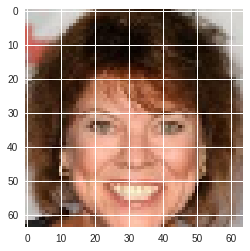

In [18]:
plt.imshow(batch_xs[0] / 255.0)